In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

c:\Users\Scent\anaconda3\envs\CENT002\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

batch_size = 64
train_dataloader = DataLoader(mnist_train,batch_size,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size,shuffle=False)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

GPU name: NVIDIA GeForce GTX 1660
Using device: cuda


In [4]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size) #(b,p,k,k)

    return kernels

In [5]:
#EncoderMZM
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage

        kernel_in = kernel_size ** 2 * channels
        output_dim = int(kernel_in/leverage)
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

    def forward(self, x):

        alpha = torch.rand(1).item() * 0.5 + 0.5#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        b, n_patches,  k, _ = x.shape
        x = x.reshape(b*n_patches, -1)  #(b*p,c*k*k)
        x = 1+torch.exp(1j * alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  #(b*p,c*k*k/l)
        x = torch.abs(x)**2 
        return x

In [6]:
class MLP(nn.Module):
    def __init__(self,potential_dim):
        super(MLP, self).__init__()
        mid_num = int(potential_dim/2)
        self.fc1 = nn.Linear(potential_dim, mid_num) 
        self.fc2 = nn.Linear(mid_num, 10)
        self.func = nn.Tanh()

    def forward(self, x):
        x = self.func(self.fc1(x))  # 隠れ層
        x = self.fc2(x)  # 出力層
        return x

In [7]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()

        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        
        kernel_in = channels*kernel_size**2
        feat_dim = int(kernel_in/leverage)
        num_patches = (28//kernel_size)*(28//kernel_size)
        potential_dim = num_patches * feat_dim
        self.split = split_into_kernels
        self.encoder = Encoder(kernel_size,leverage,channels) 
        self.bn = nn.BatchNorm1d(feat_dim)#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        b=x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)  
        x = self.split(x, self.kernel_size) 
        x = self.encoder(x) 
        x = self.bn(x)#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        x = x.reshape(b, -1)
        x = self.classifier(x)
        return x

1:2 1th Epoch: 9/10

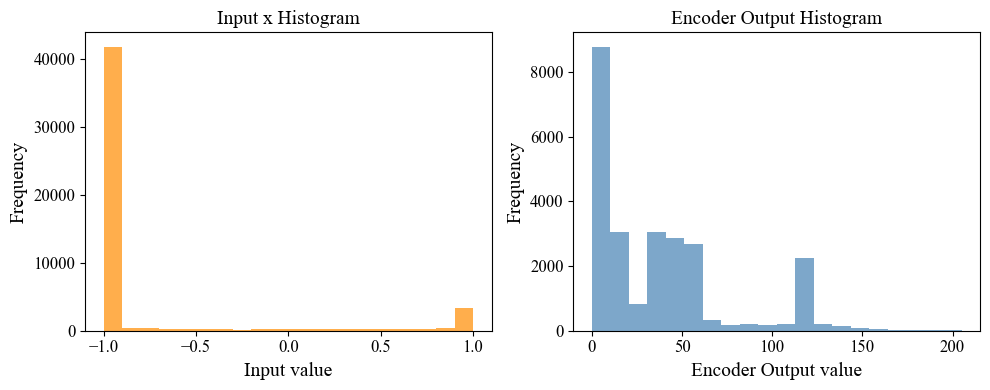

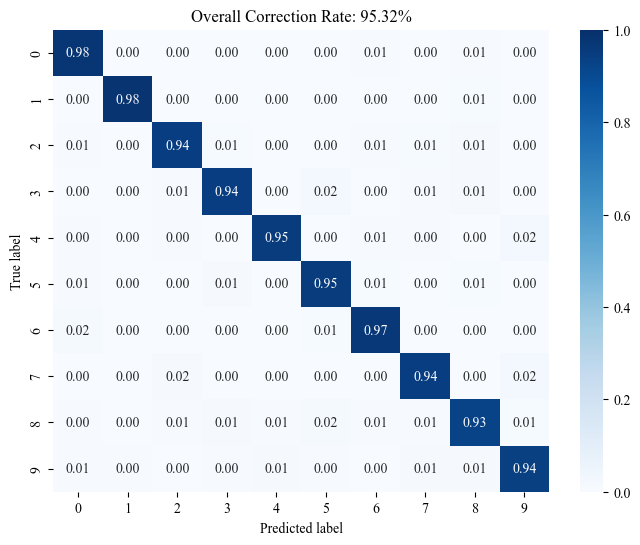

1:2 2th Epoch: 9/10

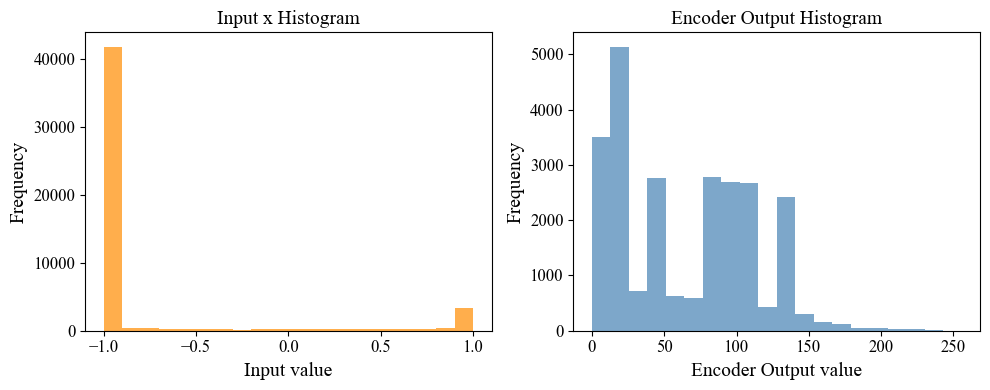

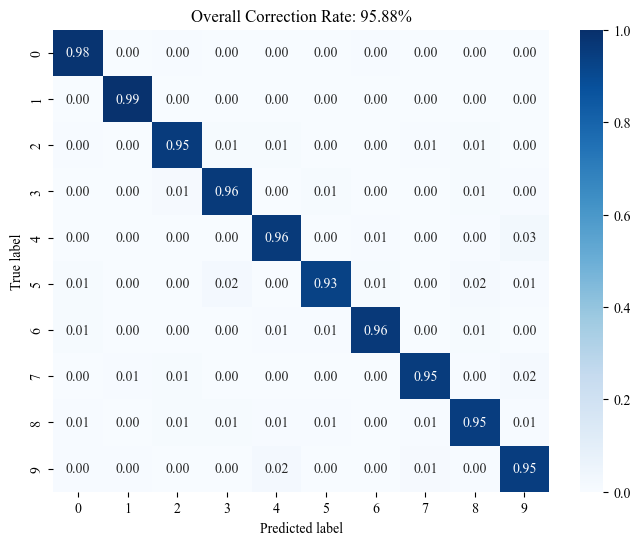

1:2 3th Epoch: 9/10

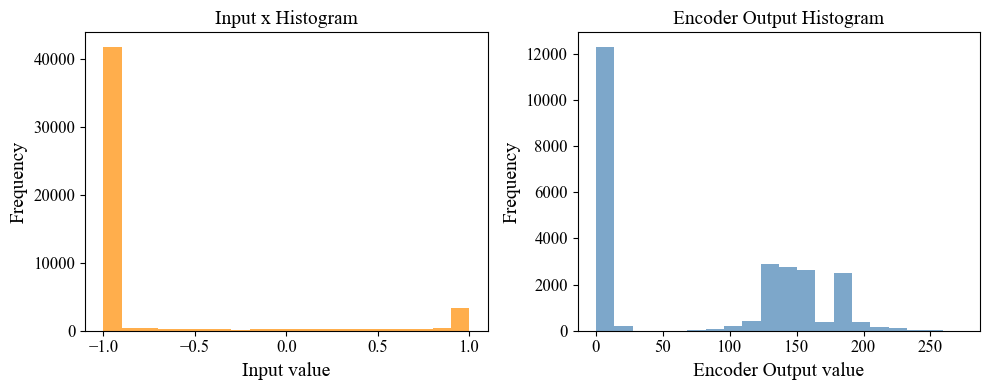

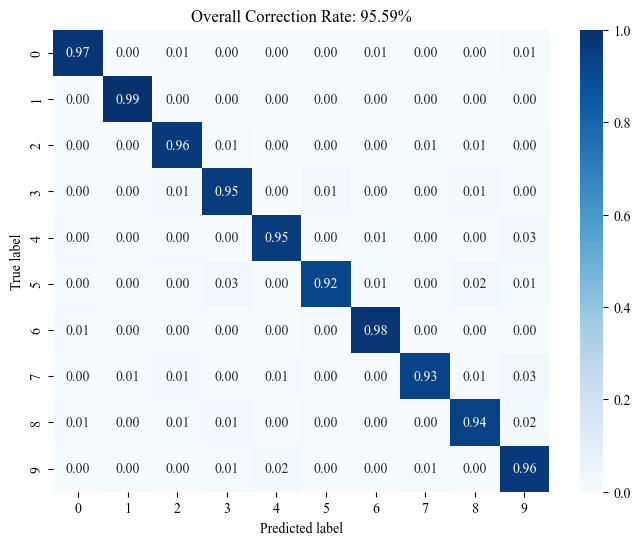

1:2 4th Epoch: 9/10

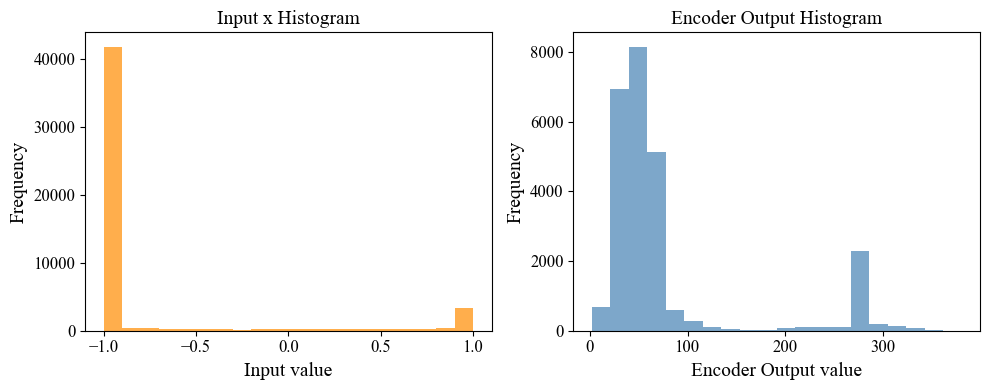

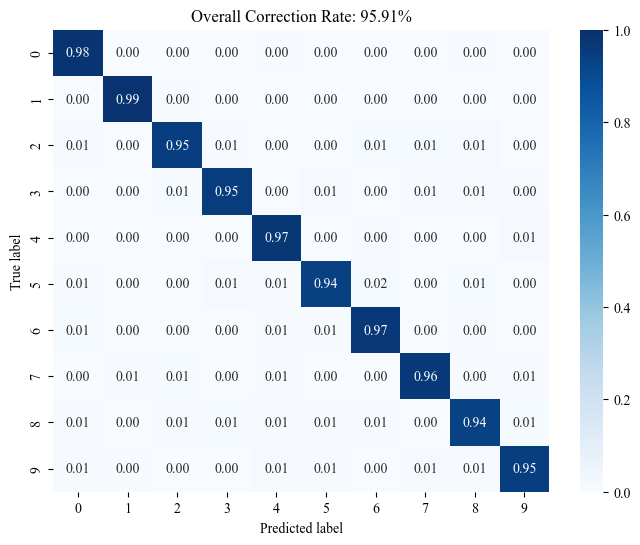

1:2 5th Epoch: 9/10

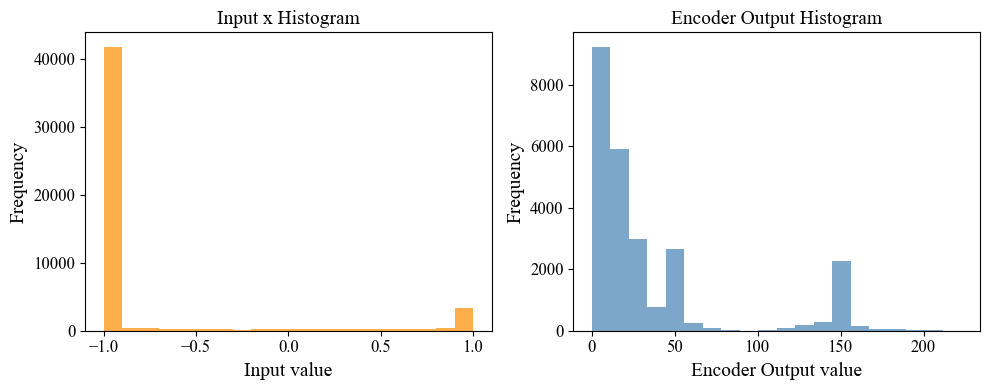

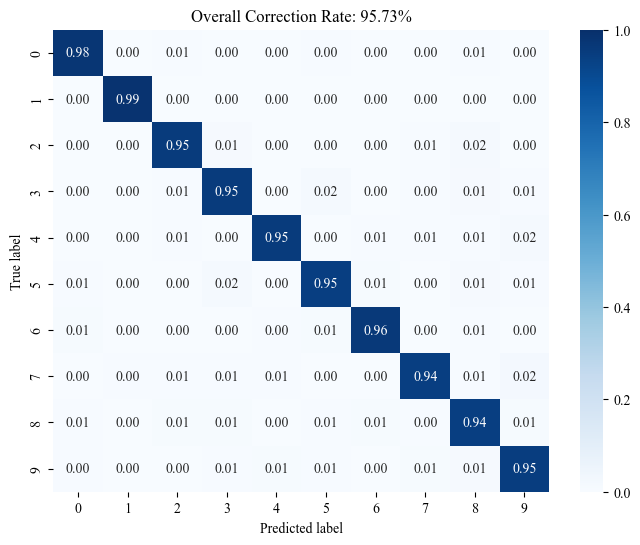

          Average  Best ID       Best  Worst ID      Worst
0   ACC  95.68600        4  95.910000         1  95.320000
1  LOSS   0.15209        2   0.143234         1   0.162804


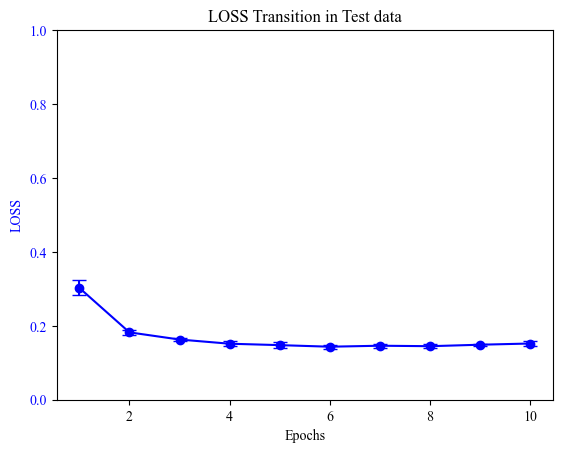

1:4 1th Epoch: 9/10

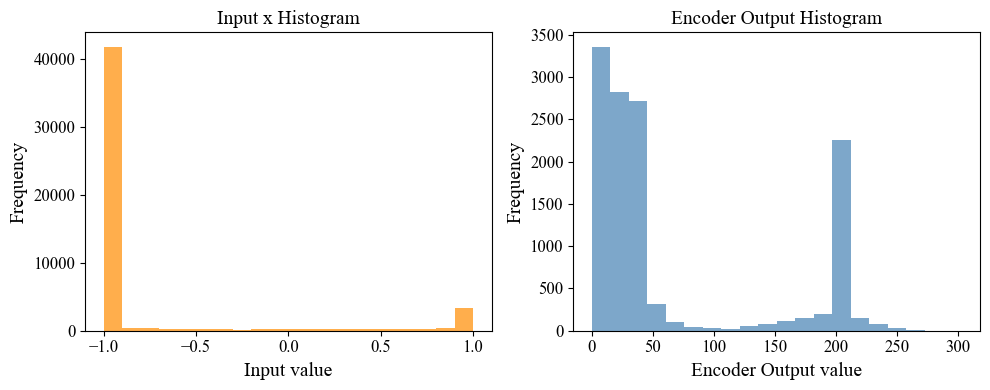

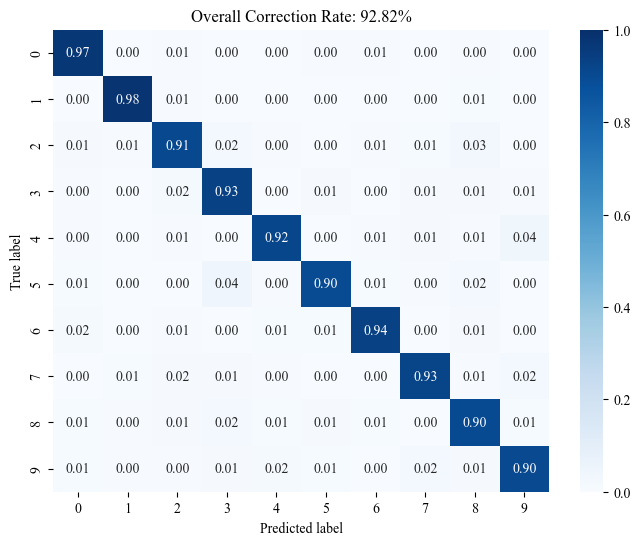

1:4 2th Epoch: 9/10

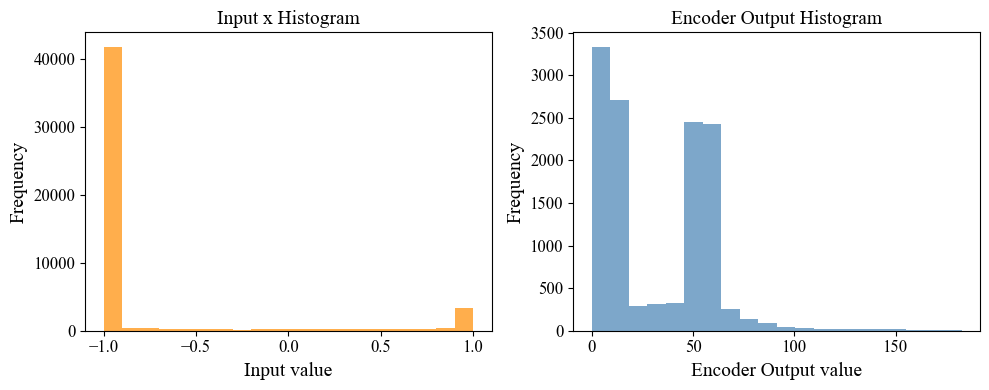

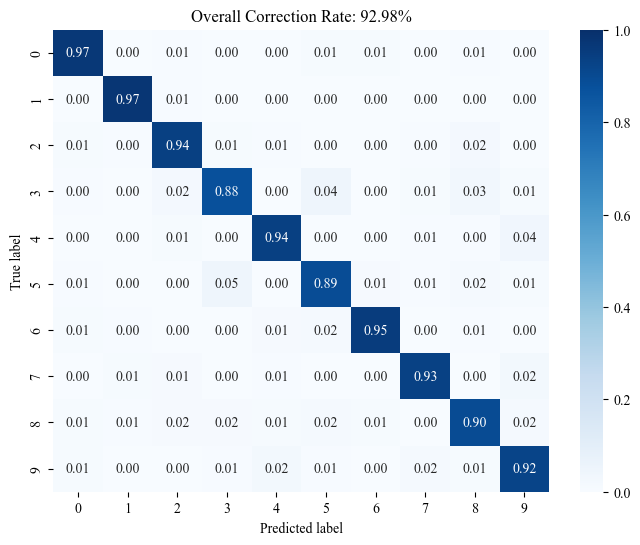

1:4 3th Epoch: 9/10

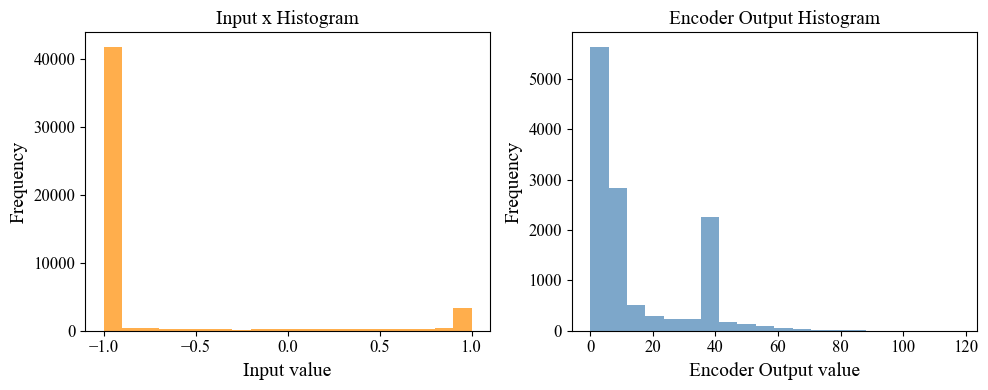

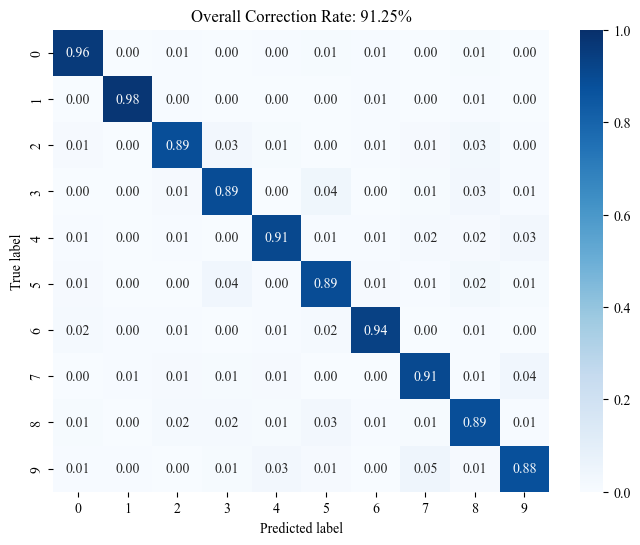

1:4 4th Epoch: 9/10

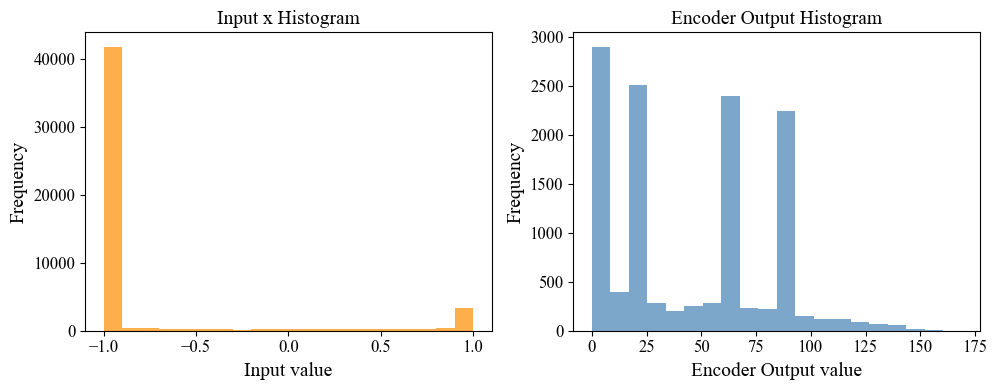

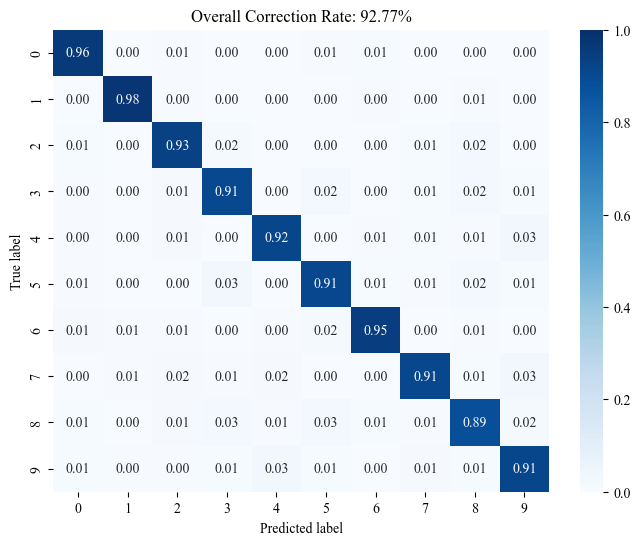

1:4 5th Epoch: 9/10

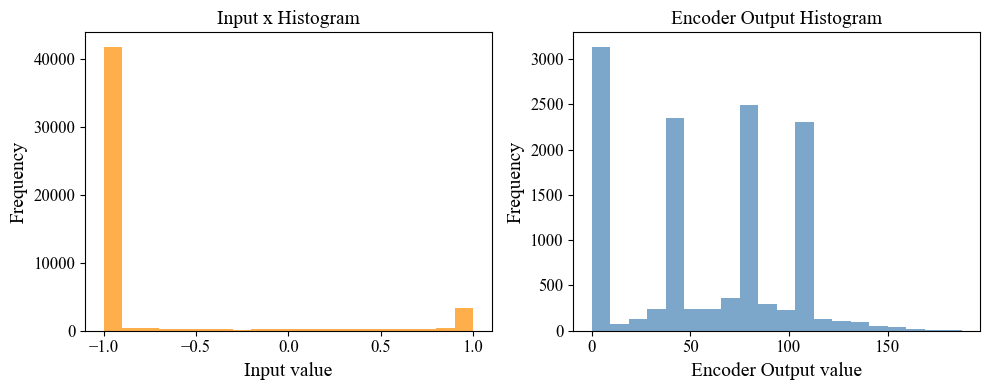

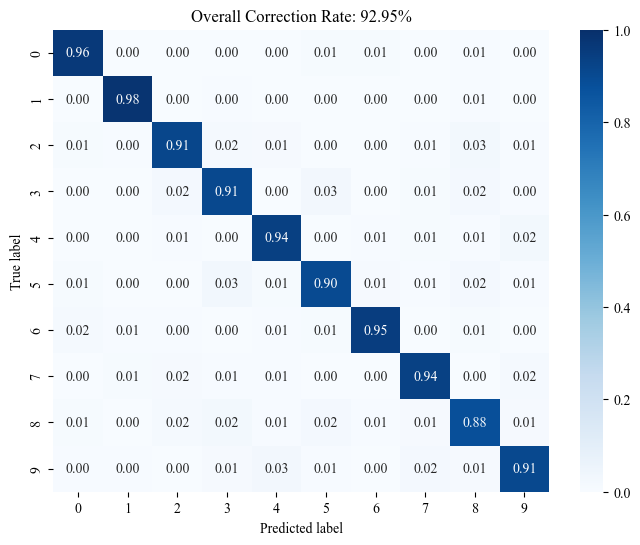

           Average  Best ID       Best  Worst ID      Worst
0   ACC  92.554000        2  92.980000         3  91.250000
1  LOSS   0.236677        2   0.219541         3   0.282001


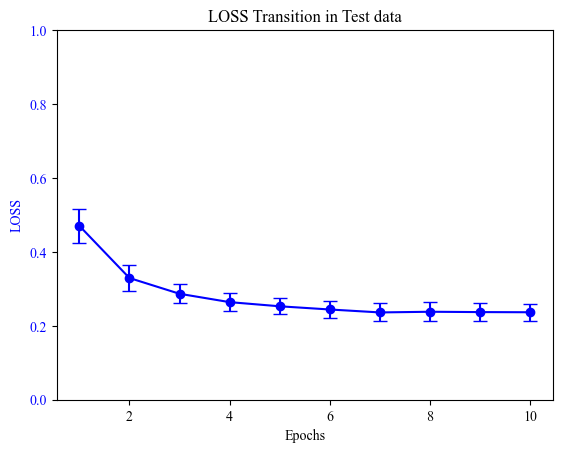

1:8 1th Epoch: 9/10

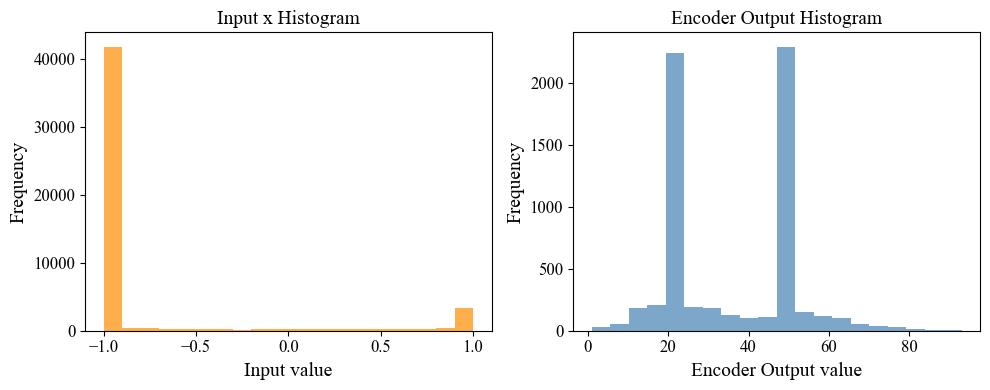

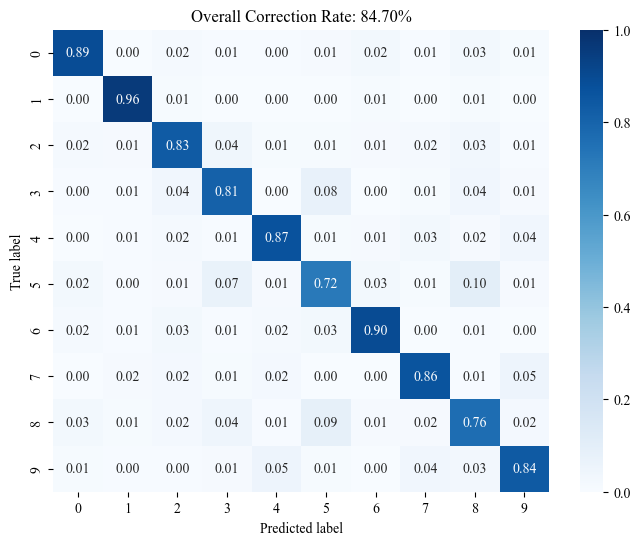

1:8 2th Epoch: 9/10

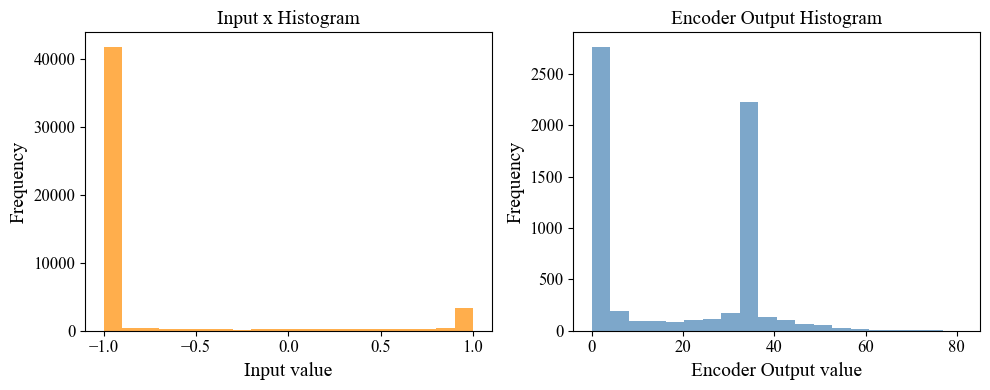

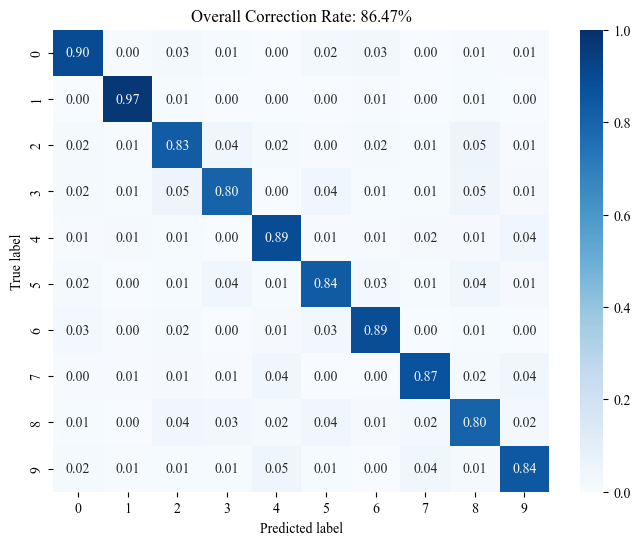

1:8 3th Epoch: 9/10

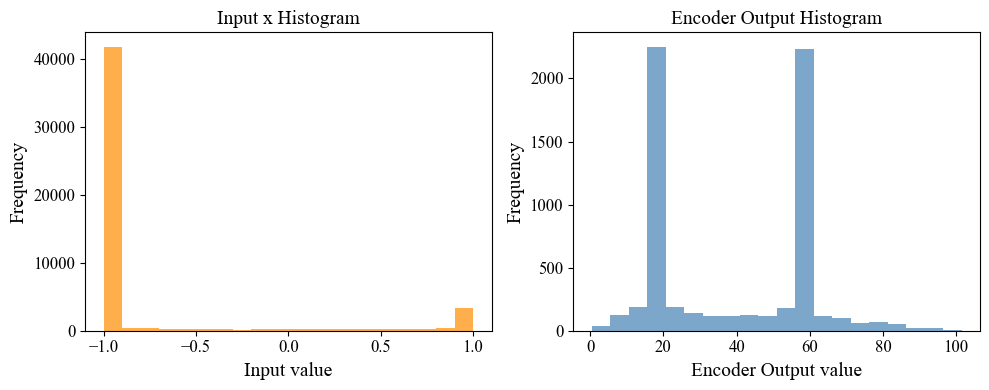

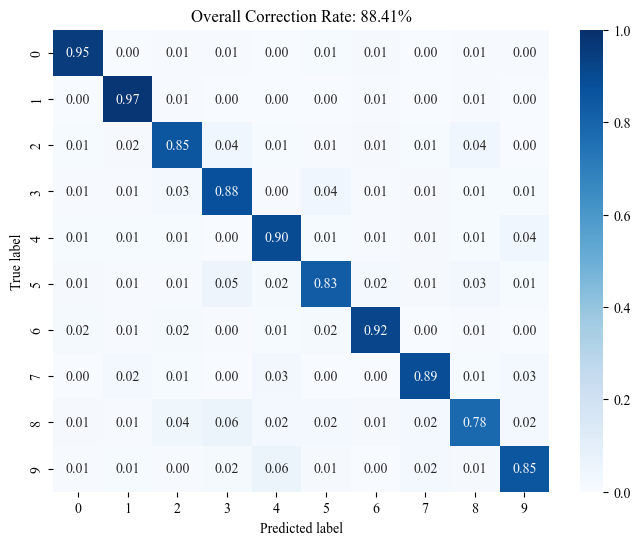

1:8 4th Epoch: 9/10

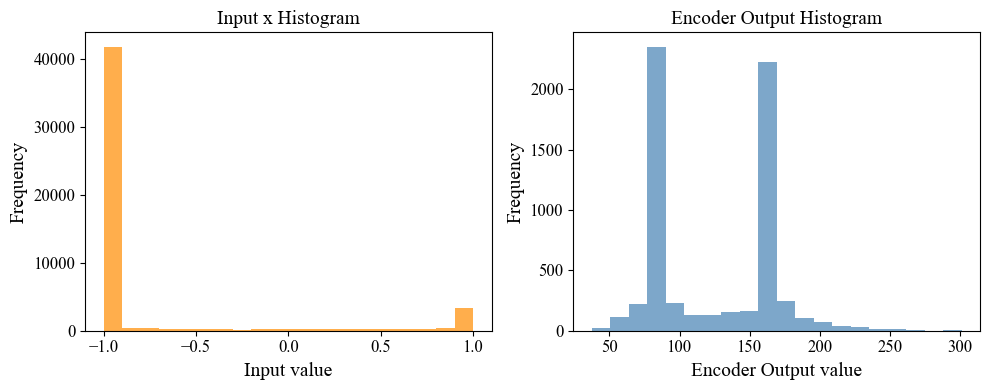

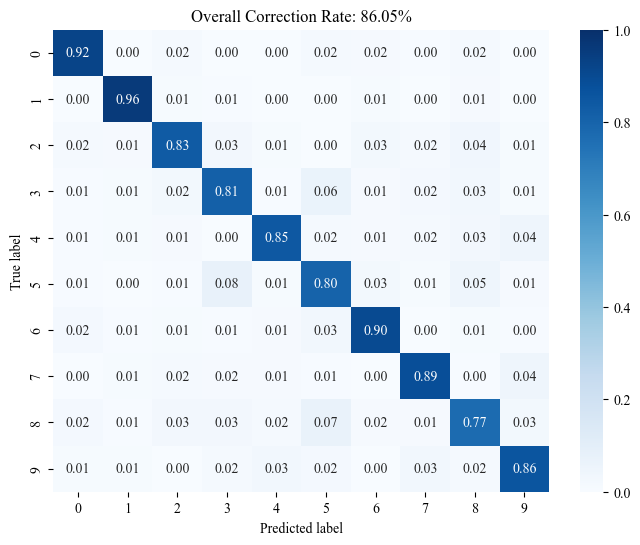

1:8 5th Epoch: 9/10

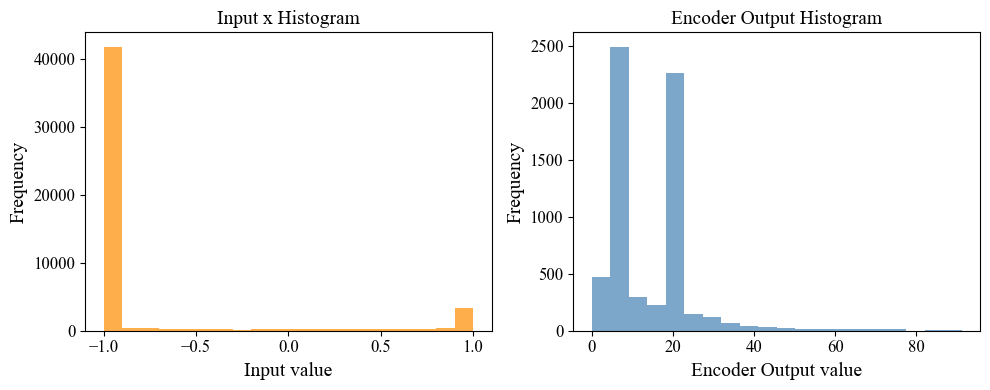

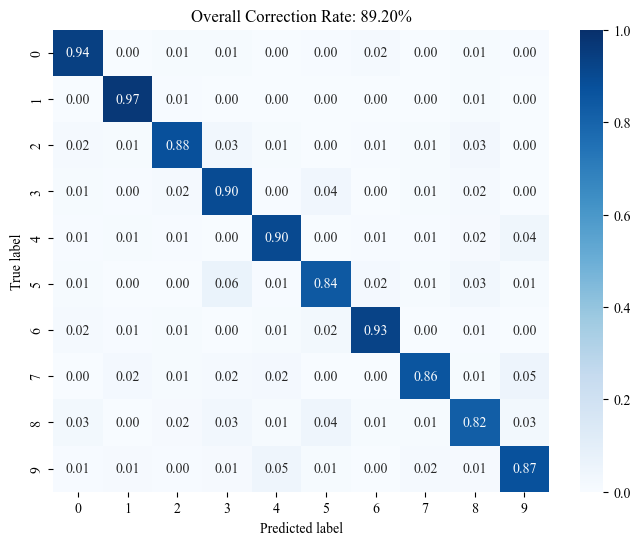

           Average  Best ID       Best  Worst ID     Worst
0   ACC  86.966000        5  89.200000         1  84.70000
1  LOSS   0.421389        5   0.353391         1   0.49089


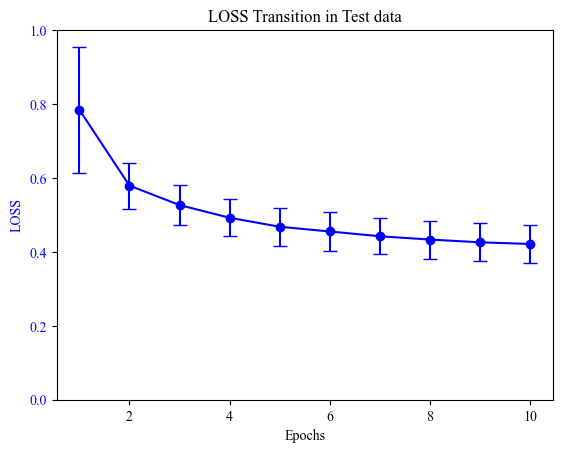

1:16 1th Epoch: 9/10

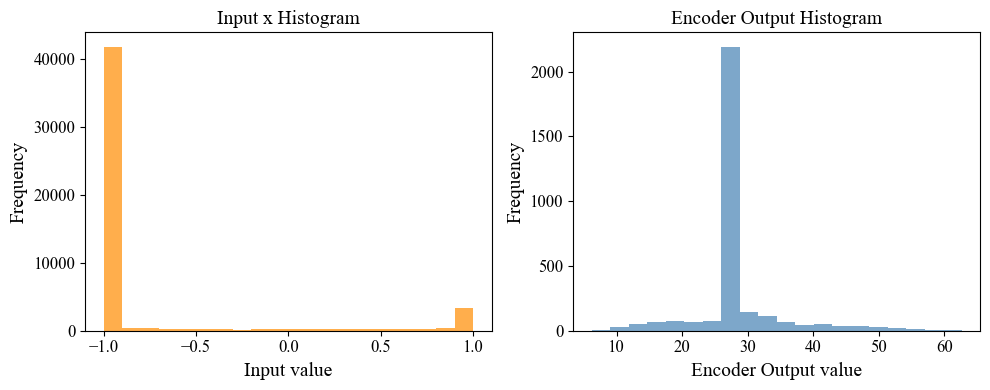

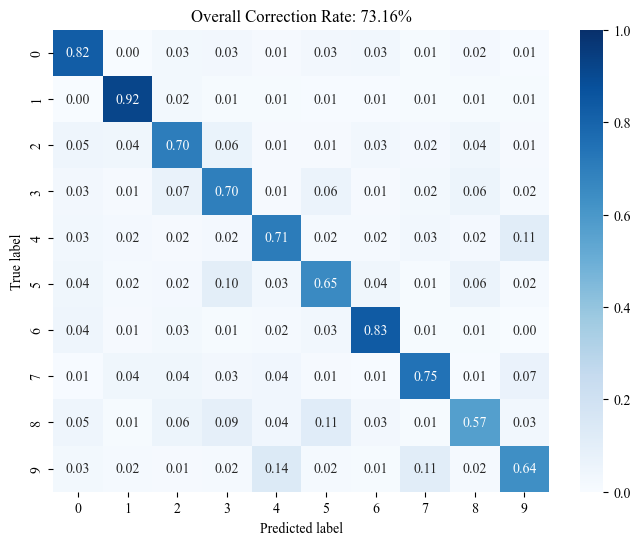

1:16 2th Epoch: 9/10

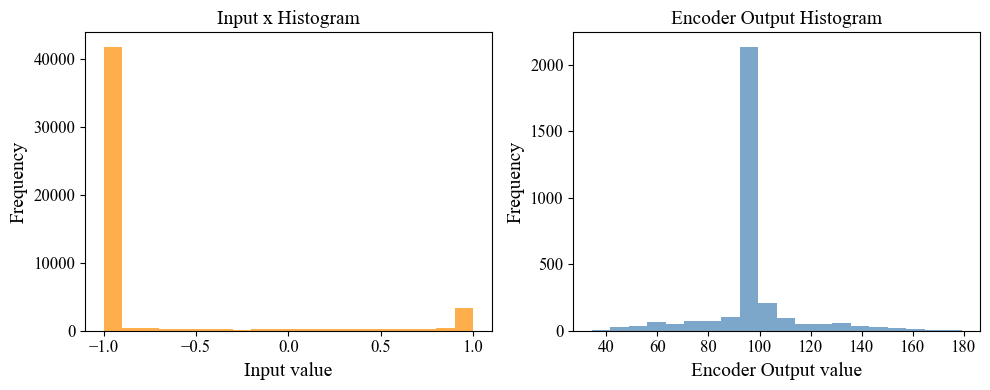

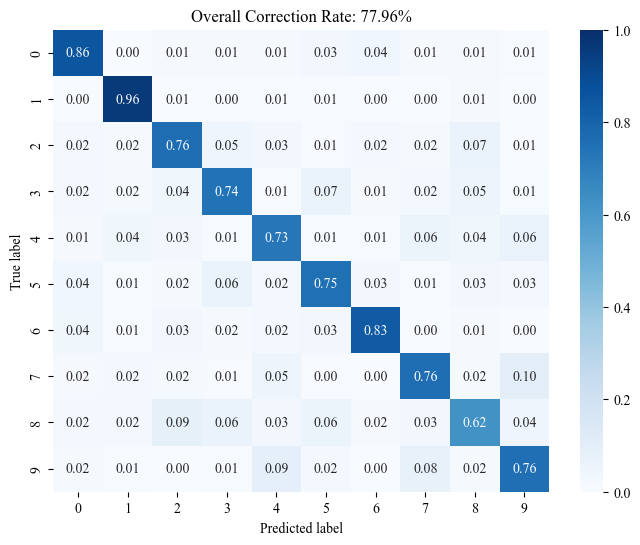

1:16 3th Epoch: 9/10

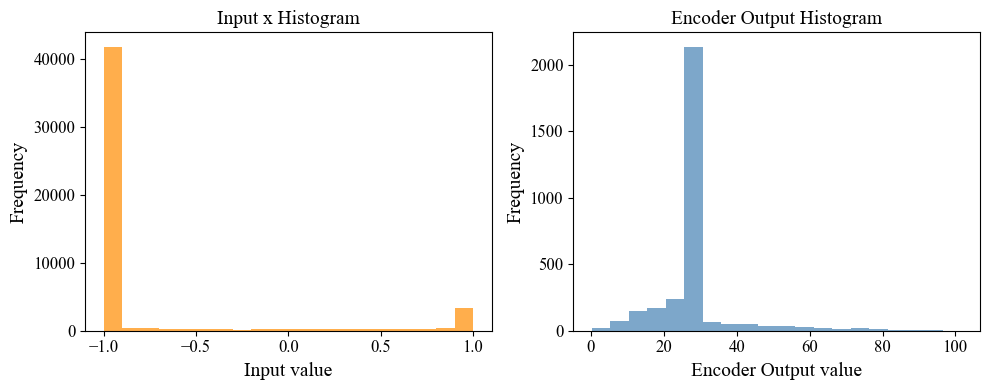

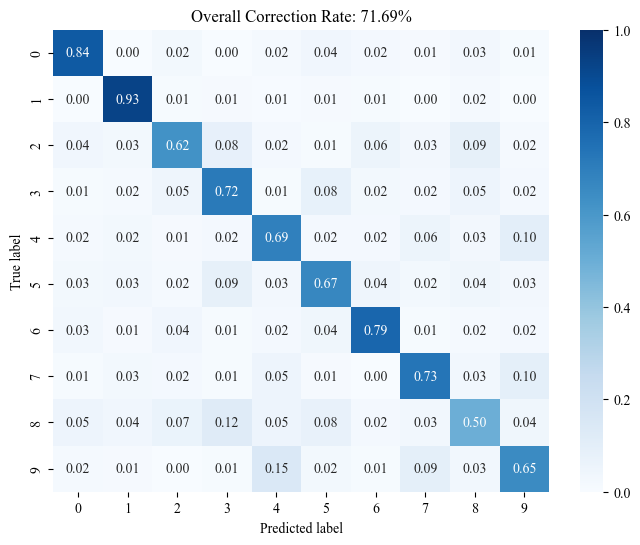

1:16 4th Epoch: 9/10

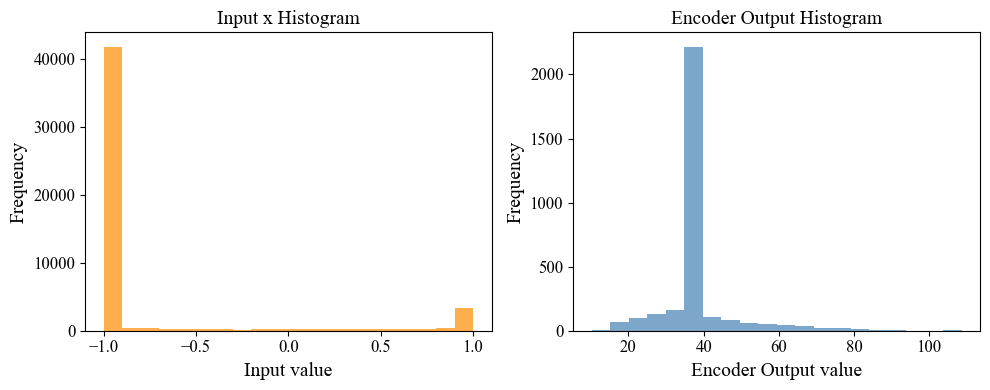

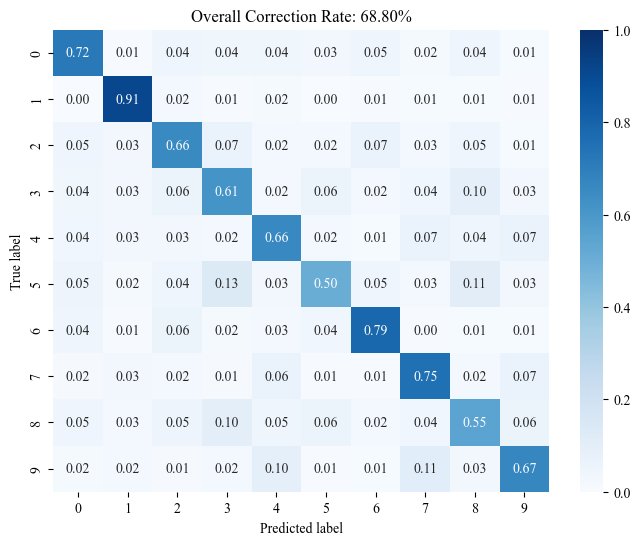

1:16 5th Epoch: 9/10

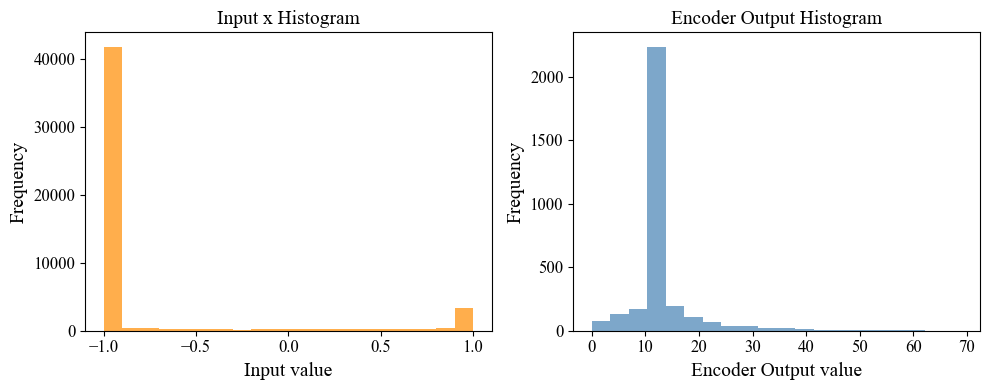

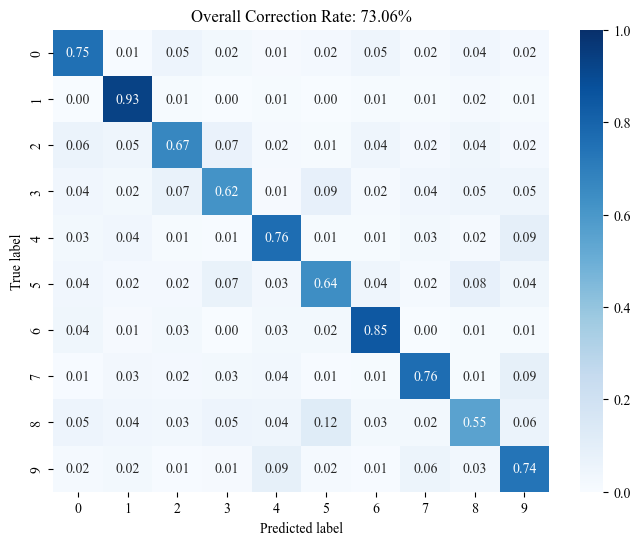

           Average  Best ID       Best  Worst ID      Worst
0   ACC  72.934000        2  77.960000         4  68.800000
1  LOSS   0.844798        2   0.712326         4   0.980887


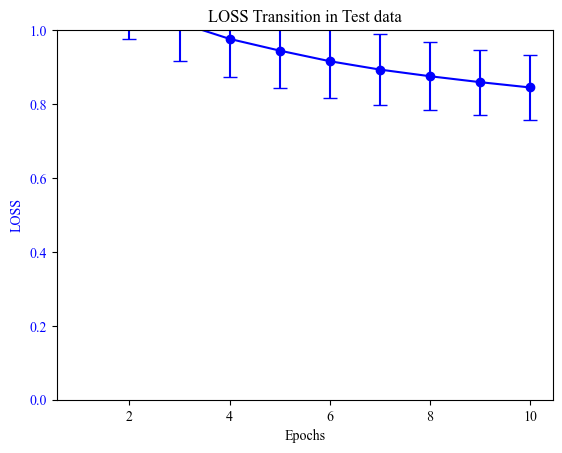

In [8]:
img_size = 28
channels = 1

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
#leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
max_epochs = 10#20

num_try = 5##5

leverages = [2,4,8,16]
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
for leverage in leverages: 
    
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(1,num_try+1): 

        model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

                
        for epoch in range(max_epochs):

            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times, epoch, max_epochs)) 
            sys.stderr.flush()

            loss_train = 0
            loss_test = 0

            start_time1 = time.time()
            for (x,t) in train_dataloader:
                    
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, t) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
        
            loss_train_avg = loss_train / len(train_dataloader)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)


            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                correct = 0
                total = 0
                first_batch = True
                for x, t in test_dataloader:
                    x, t = x.to(device), t.to(device)
                    y = model(x).to(device)
                    _, predicted = torch.max(y, 1)
                    loss = criterion(y,t)
                    loss_test += loss.item()        
                    total += t.size(0)
                    correct += (predicted == t).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(t.cpu().numpy()) 
                    if epoch == max_epochs - 1:
                        if first_batch:
                            x = x.view(batch_size, channels, img_size, img_size)  
                            x_splitted = model.split(x, kernel_size)
                            x_in_flat = x_splitted.reshape(-1).detach().cpu().numpy()
                            x_encoded = model.encoder(x_splitted)
                            x_out_flat = x_encoded.reshape(-1).detach().cpu().numpy()

                            # サブプロットで横に並べて表示
                            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                            # 入力ヒストグラム
                            axes[0].hist(x_in_flat, bins=20, color='darkorange', alpha=0.7)
                            axes[0].set_xlabel("Input value", fontsize=14)
                            axes[0].set_ylabel("Frequency", fontsize=14)
                            axes[0].set_title("Input x Histogram", fontsize=14)
                            axes[0].tick_params(labelsize=12)
                            axes[0].set_ylim(0,)

                            # エンコーダ出力ヒストグラム
                            axes[1].hist(x_out_flat, bins=20, color='steelblue', alpha=0.7)
                            axes[1].set_xlabel("Encoder Output value", fontsize=14)
                            axes[1].set_ylabel("Frequency", fontsize=14)
                            axes[1].set_title("Encoder Output Histogram", fontsize=14)
                            axes[1].tick_params(labelsize=12)

                            plt.tight_layout()
                            plt.show()

                            first_batch = False
            
            #print(f"Test Accuracy: {100 * correct / total:.2f}%")
            loss_test_avg = loss_test / len(test_dataloader)

            loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
            #if epoch == max_epochs-1:
        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_)) 

        cm = confusion_matrix(all_labels, all_preds)
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)
        Test_acc = 100 * correct / total
        All_test_acc.append(Test_acc)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10),vmin=0.0, vmax=1.0)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Overall Correction Rate: {Test_acc:.2f}%")
        plt.show()

    All_last_LOSSs_.append(All_last_loss)
    All_last_ACCs_.append(All_test_acc)
    
    ACC_mean = np.mean(All_test_acc)
    ACC_best = np.max(All_test_acc)
    ACC_bestID = np.argmax(All_test_acc)+1
    ACC_worst = np.min(All_test_acc)
    ACC_worstID = np.argmin(All_test_acc)+1

    LOSS_mean = np.mean(All_last_loss)
    LOSS_best = np.min(All_last_loss)
    LOSS_bestID = np.argmin(All_last_loss)+1
    LOSS_worst = np.max(All_last_loss)
    LOSS_worstID = np.argmax(All_last_loss)+1

    data = {
            "": ["ACC", "LOSS"],
        "Average": [ACC_mean, LOSS_mean],
        "Best ID": [ACC_bestID, LOSS_bestID],
        "Best": [ACC_best, LOSS_best],
        "Worst ID": [ACC_worstID, LOSS_worstID],
        "Worst": [ACC_worst, LOSS_worst],
    }

    df = pd.DataFrame(data)
    results.append(data)
    print(df)
    epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
    num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

    # 各エポックごとに平均と標準偏差を計算
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    # グラフの描画
    fig, ax1 = plt.subplots()

    # 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    # 軸ラベルやタイトルの設定
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('LOSS Transition in Test data')
    plt.ylim(0,1.0)
    plt.show()


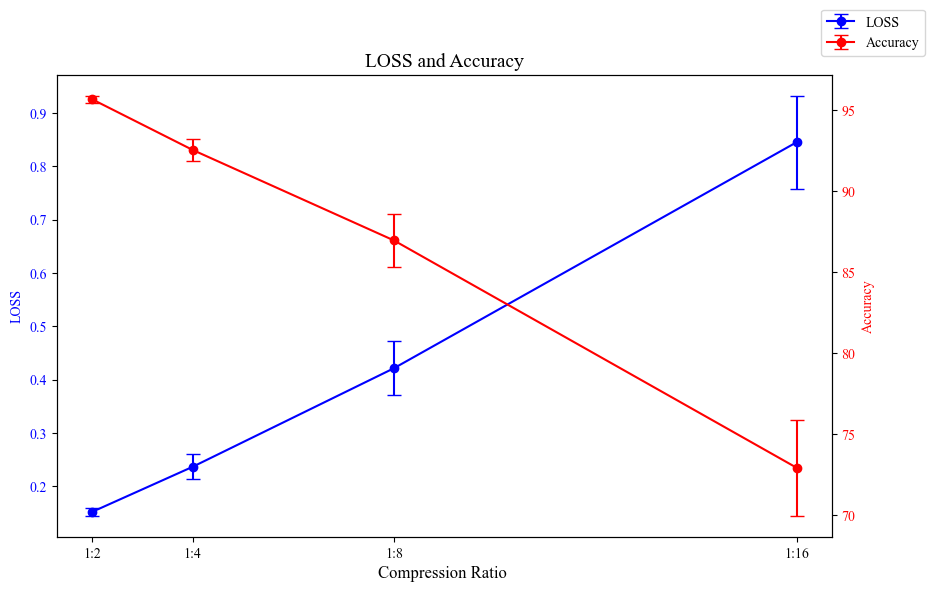

In [9]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[2,4,8,16]

# LOSS用の平均値と標準偏差を計算
loss_means = [np.mean(loss_list) for loss_list in All_last_LOSSs_]
loss_stds = [np.std(loss_list) for loss_list in All_last_LOSSs_]

# ACC用の平均値と標準偏差を計算
acc_means = [np.mean(acc_list) for acc_list in All_last_ACCs_]
acc_stds = [np.std(acc_list) for acc_list in All_last_ACCs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=loss_means, yerr=loss_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='LOSS'
)
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=acc_means, yerr=acc_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='Accuracy'
)
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('LOSS and Accuracy', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)
plt.show()

In [10]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)

           Average  Best ID       Best  Worst ID      Worst
0   ACC  95.686000        4  95.910000         1  95.320000
1  LOSS   0.152090        2   0.143234         1   0.162804
2   ACC  92.554000        2  92.980000         3  91.250000
3  LOSS   0.236677        2   0.219541         3   0.282001
4   ACC  86.966000        5  89.200000         1  84.700000
5  LOSS   0.421389        5   0.353391         1   0.490890
6   ACC  72.934000        2  77.960000         4  68.800000
7  LOSS   0.844798        2   0.712326         4   0.980887


In [11]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','MNIST_texts')  
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_VCR_MZM_Class01_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_LOSSs_)
    writer.writerow(All_last_ACCs_)

C:\Users\Scent\OneDrive\CODES\konishi_Classifer\data\MNIST_texts
